# CSE416 - Final Project: Link Prediction

name: Angelica Tao Zhu, Yue Lin

In [3]:
import networkx as nx
import numpy as np

# load General Relativity and Quantum Cosmology collaboration network from text file
collaboration_network = nx.Graph()
with open("dataset/ca-GrQc.txt", "r") as fp:
    line = fp.readline()
    # skip comments
    while line[0] == '#':
        line = fp.readline()
        
    while line:
        edge = line.split()
        collaboration_network.add_edge(edge[0], edge[1])
        line = fp.readline()

# load facebook ego network
facebook_ego = nx.Graph()
with open("dataset/facebook_combined.txt", "r") as fp:
    line = fp.readline()
        
    while line:
        edge = line.split()
        facebook_ego.add_edge(edge[0], edge[1])
        line = fp.readline()
        
# load email-Eu-core temporal network
email_eu = nx.Graph()
with open("dataset/email-Eu-core-temporal.txt", "r") as fp:
    line = fp.readline()
    while line:
        edge = line.split()
        email_eu.add_edge(edge[0], edge[1])
        line = fp.readline()

In [56]:
import networkx as nx
import numpy as np

facebook = nx.Graph()
with open("dataset/facebook.txt", "r") as fp:
    line = fp.readline()
    # skip comments
    while line[0] == '#':
        line = fp.readline()
    while line:
        edge = line.split()
        facebook.add_edge(edge[0], edge[1])
        line = fp.readline()

In [4]:
def loadGraph(fileName):
    g = nx.Graph()
    with open("dataset/" + fileName + ".txt", "r") as fp:
        line = fp.readline()
        
        # skip comments
        while line[0] == '#':
            line = fp.readline()
            
        while line:
            edge = line.split()
            g.add_edge(edge[0], edge[1])
            line = fp.readline()
    return g

In [5]:
def splitFile(fileName, percentage):
    filePath = 'dataset/' + fileName + '.txt'
    num_lines = sum(1 for line in open(filePath))
    num_train_lines = int(num_lines * percentage)
    with open(filePath) as fp:
        count = 1
        line = fp.readline()
        
        trainf = open('dataset/' + fileName + '_train.txt', "w")
        while count < num_train_lines:
            trainf.write(line)
            line = fp.readline()
            count += 1
        
        testf = open('dataset/' + fileName + '_test.txt', "w")
        while line:
            testf.write(line)
            line = fp.readline()

In [6]:
def _apply_prediction(G, func, ebunch=None):
    """Applies the given function to each edge in the specified iterable
    of edges.

    `G` is an instance of :class:`networkx.Graph`.

    `func` is a function on two inputs, each of which is a node in the
    graph. The function can return anything, but it should return a
    value representing a prediction of the likelihood of a "link"
    joining the two nodes.

    `ebunch` is an iterable of pairs of nodes. If not specified, all
    non-edges in the graph `G` will be used.

    """
    if ebunch is None:
        ebunch = nx.non_edges(G)
    return [(u, v, func(u, v)) for u, v in ebunch]

In [7]:
def jaccard_coefficient(G, ebunch=None):
    """Compute the Jaccard coefficient of all node pairs in ebunch.

    Jaccard coefficient of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    Examples
    --------
    >>> import networkx as nx
    >>> G = nx.complete_graph(5)
    >>> preds = nx.jaccard_coefficient(G, [(0, 1), (2, 3)])
    >>> for u, v, p in preds:
    ...     '(%d, %d) -> %.8f' % (u, v, p)
    ...
    '(0, 1) -> 0.60000000'
    '(2, 3) -> 0.60000000'

    References
    ----------
    .. [1] D. Liben-Nowell, J. Kleinberg.
           The Link Prediction Problem for Social Networks (2004).
           http://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    """
    def predict(u, v):
        union_size = len(set(G[u]) | set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [8]:
def sorensen_index(G, ebunch=None):
    """Compute the Sorensen Index of all node pairs in ebunch.

    Sorensen Index of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u)| + |\Gamma(v)|}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        union_size = len(set(G[u])) + len(set(G[v]))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [9]:
def salton_cosine_similarity(G, ebunch=None):
    """Compute the Salton Cosine Similarity of all node pairs in ebunch.

    Salton Cosine Similarity of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        import math
        union_size = math.sqrt(len(set(G[u])) * len(set(G[v])))
        if union_size == 0:
            return 0
        return len(list(nx.common_neighbors(G, u, v))) / union_size
    return _apply_prediction(G, predict, ebunch)

In [10]:
def preferential_attachment(G, ebunch=None):
    """Compute the Preferential Attachment of all node pairs in ebunch.

    Preferential Attachment of nodes `u` and `v` is defined as

    .. math::

        \frac{|\Gamma(u) \cap \Gamma(v)|}{\sqrt{|\Gamma(u)| \times |\Gamma(v)|}}

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        return len(set(G[u])) * len(set(G[v]))
    return _apply_prediction(G, predict, ebunch)

In [11]:
def rank(pred):
    """
    Parameters
    ----------
    pred : An list of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.

    k : keep top k element based p

    Returns
    -------
    top k list
    """
    
    sorted_l = sorted(pred, key=lambda x: x[2], reverse=True)
    return sorted_l

In [12]:
# evaluating prediction quality

def prediction_eval(G, true_links, pred_links):
    """
    G: network before prediction
    """
    true_links = set(true_links)
    pred_links = set(pred_links)
    TP = 0; TN = 0; FP = 0; FN = 0

    for u, v in nx.non_edges(G):
        in_true_links = ((u,v) in true_links or (v,u) in true_links)
        in_pred_links = ((u,v) in pred_links or (v,u) in pred_links)
        
        if in_true_links and in_pred_links:
            TP += 1
        elif not in_true_links and in_pred_links:
            FP += 1
        elif in_true_links and not in_pred_links:
            FN += 1
        else:
            TN += 1
    
#     print (TP, FP, FN, TN)
#     precision = TP / (TP + FP)
    return TP, FP, FN, TN

In [13]:
# load true links
def load_true_links(filename):
    # load true links
    true_links = []
    with open(filename, "r") as fp:
        line = fp.readline()

        # skip comments
        while line[0] == '#':
            line = fp.readline()

        while line:
            edge = line.split()
            true_links.append((edge[0], edge[1]))
            line = fp.readline()
    
    return true_links

In [80]:
def katz_based_metric(G, cutoff=3, beta=0.8, ebunch=None):
    """Compute the Katz based metric of all node pairs in ebunch.

    Katz based metric of nodes `u` and `v` is defined as

    .. math::

        Katz(x, y) = βA + β2A2 + β3A3 + ...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        curB = 1
        katz = 0
        c = compute_num_of_path(forum_train_g, u, v, cutoff)
        for i in range(1, cutoff + 1):
            curB *= beta
            katz += curB * c[i]
        return katz
    return _apply_prediction(G, predict, ebunch)

In [81]:
def local_path_based_metric(G, alpha=0.8, ebunch=None):
    """Compute the Local Path based metric of all node pairs in ebunch.

    Local Path based metric of nodes `u` and `v` is defined as

    .. math::

        lp(x, y) = A2 + alpha*A3...

    where $\Gamma(u)$ denotes the set of neighbors of $u$.

    Parameters
    ----------
    G : graph
        A NetworkX undirected graph.

    ebunch : iterable of node pairs, optional (default = None)
        Jaccard coefficient will be computed for each pair of nodes
        given in the iterable. The pairs must be given as 2-tuples
        (u, v) where u and v are nodes in the graph. If ebunch is None
        then all non-existent edges in the graph will be used.
        Default value: None.

    Returns
    -------
    piter : iterator
        An iterator of 3-tuples in the form (u, v, p) where (u, v) is a
        pair of nodes and p is their Jaccard coefficient.
    """
    def predict(u, v):
        c = compute_num_of_path(forum_train_g, u, v, 3)
        return c[2] + alpha * c[3]
    return _apply_prediction(G, predict, ebunch)

In [16]:
def commute_time_based_metric(G, ebunch=None):
    """Compute the commute time based metric of all node pairs in ebunch.

    commute time based metric of nodes `u` and `v` is defined as

    .. math::

        CT(x, y) = HT(x, y) + HT(y, x) = m(L†x,x + L†y,y − 2L†x,y),

    where L† is the pseudo-inverse of matrix L = DA − A and m is number of edges in a social network.

    """
    import networkx as nx, numpy as np
    nodelist = sorted(G.nodes)
    L = nx.laplacian_matrix(G, nodelist=nodelist).toarray()
    CTK = np.linalg.pinv(L) # L†
    m = len(G.edges())
    def predict(u, v):
        ind_u = nodelist.index(u)
        ind_v = nodelist.index(v)
        return 1/((CTK[ind_u][ind_u] + CTK[ind_v][ind_v] - 2*CTK[ind_v][ind_u]))
    return _apply_prediction(G, predict, ebunch)

In [17]:
def rooted_pagerank(G, ebunch=None):
    """
    Use linkpred to compute rooted pagerank
    link: https://github.com/rafguns/linkpred/tree/c3157208017b73798e8e9ba8223064bb5d34e1db
    """
    
    from linkpred.predictors.eigenvector import RootedPageRank
    return RootedPageRank(G).predict()

In [18]:
# https://stackoverflow.com/questions/9767773/calculating-simrank-using-networkx

from collections import defaultdict
import copy
import sys

# def iter_to_list(iterator):
#     l = []
#     for item in iterator:
#         l.append(item)
#     return l

# def simrankmatrix(G, r=0.9, max_iter=100):
#     # init. vars
#     sim_old = defaultdict(list)
#     sim = defaultdict(list)
#     for n in G.nodes():
#         sim[n] = defaultdict(int)
#         sim[n][n] = 1
#         sim_old[n] = defaultdict(int)
#         sim_old[n][n] = 0

#     # recursively calculate simrank
#     for iter_ctr in range(max_iter):
#         if _is_converge(sim, sim_old):
#             break
#         sim_old = copy.deepcopy(sim)
#         for u in G.nodes():
#             for v in G.nodes():
#                 if u == v:
#                     continue
#                 s_uv = 0.0
#                 for n_u in G.neighbors(u):
#                     for n_v in G.neighbors(v):
#                         s_uv += sim_old[n_u][n_v]
#                 sim[u][v] = (r * s_uv / (len(iter_to_list(G.neighbors(u))) * len(iter_to_list(G.neighbors(v)))))
#     return sim

# def _is_converge(s1, s2, eps=1e-4):
#     for i in s1.keys():
#         for j in s1[i].keys():
#             if abs(s1[i][j] - s2[i][j]) >= eps:
#                 return False
#     return True

# def sim_rank_metric(G, ebunch=None):
#     """Compute the commute time based metric of all node pairs in ebunch.

#     commute time based metric of nodes `u` and `v` is defined as

#     .. math::

#         CT(x, y) = HT(x, y) + HT(y, x) = m(L†x,x + L†y,y − 2L†x,y),

#     where L† is the pseudo-inverse of matrix L = DA − A and m is number of edges in a social network.

#     """
#     import networkx as nx, numpy as np
#     nodelist = sorted(G.nodes)
#     sim_rank_matrix = simrankmatrix(G)
#     def predict(u, v):
#         ind_u = nodelist.index(u)
#         ind_v = nodelist.index(v)
#         return sim_rank_matrix[ind_u][ind_v]
#     return _apply_prediction(G, predict, ebunch)
# ---------------------------------------------------------------------------
# IndexError                                Traceback (most recent call last)
# <ipython-input-27-2462a43456c7> in <module>
#       6     import time
#       7     start_time = time.time()
# ----> 8     pred = method(email_train_g)
#       9     runtime = time.time() - start_time
#      10 

# <ipython-input-16-dde101875b5e> in sim_rank_metric(G, ebunch)
#      63         ind_v = nodelist.index(v)
#      64         return sim_rank_matrix[ind_u][ind_v]
# ---> 65     return _apply_prediction(G, predict, ebunch)

# <ipython-input-4-3af494b29d1b> in _apply_prediction(G, func, ebunch)
#      16     if ebunch is None:
#      17         ebunch = nx.non_edges(G)
# ---> 18     return [(u, v, func(u, v)) for u, v in ebunch]

# <ipython-input-4-3af494b29d1b> in <listcomp>(.0)
#      16     if ebunch is None:
#      17         ebunch = nx.non_edges(G)
# ---> 18     return [(u, v, func(u, v)) for u, v in ebunch]

# <ipython-input-16-dde101875b5e> in predict(u, v)
#      62         ind_u = nodelist.index(u)
#      63         ind_v = nodelist.index(v)
# ---> 64         return sim_rank_matrix[ind_u][ind_v]
#      65     return _apply_prediction(G, predict, ebunch)

# IndexError: list index out of range
def sim_rank_metric(G):
    from linkpred.predictors.eigenvector import SimRank
    return SimRank(G).predict()

In [19]:
import collections
def compute_num_of_path(G, u, v, cutoff):
    paths = nx.all_simple_paths(G, source=u, target=v, cutoff=cutoff)
    paths_len = [len(path) - 1 for path in paths]
    return collections.Counter(paths_len)

In [72]:
splitFile('forum', 0.9)
forum_train_g = loadGraph('forum_train')

In [73]:
print(len(forum_train_g.edges()))
print(len(forum_train_g.nodes()))

6776
874


In [74]:
def convert(score_sheet):
    l = []
    for k, v in score_sheet.items():
        l.append((k.__getitem__(0), k.__getitem__(1), v))
    return l

In [82]:
methods = [sorensen_index, jaccard_coefficient, salton_cosine_similarity, preferential_attachment, katz_based_metric,local_path_based_metric, commute_time_based_metric, rooted_pagerank, sim_rank_metric]
# methods = [sim_rank_metric]
for method in methods:
    method_name = method.__name__
    print(method_name)
    import time
    start_time = time.time()
    pred = method(forum_train_g)
    runtime = time.time() - start_time
    print("here")
    if method.__name__ == "rooted_pagerank" or method.__name__ == "sim_rank_metric":
        pred = convert(pred)
    res = rank(pred)
    with open("result_forum/" + method_name + '_res.txt', 'w') as f:
        f.write("# --- runtime: %s seconds ---\n" % runtime)
        for u, v, score in res:
            f.write("%s %s %f\n" % (u, v, float(score)))

local_path_based_metric
here
commute_time_based_metric
here
rooted_pagerank
[############################################################] 874/874
here
sim_rank_metric
here


In [83]:
def loadPred(method_name):
    print(method_name)
    pred = []
    with open("result_forum/" + method_name + "_res.txt", 'r') as fp:
        line = fp.readline()
        
        # skip comments
        while line[0] == '#':
            line = fp.readline()
            
        while line:
            statistics = line.split()
            pred.append((statistics[0], statistics[1], float(statistics[2])))
            line = fp.readline()
    return pred

true_links = load_true_links("dataset/forum_test.txt")
import numpy as np

def getEval(pred):
    x = []
    TPs = []
    FPs = []
    FNs = []
    TNs = []

    for i in np.arange(100,len(pred),1000):
        res = pred[0: i]
        pred_pairs = [(u,v) for u,v,p in res]
        TP, FP, FN, TN = prediction_eval(forum_train_g, true_links, pred_pairs)
        x.append(i)
        TPs.append(TP)
        FPs.append(FP)
        TNs.append(TN)
        FNs.append(FN)
    
    return TPs, FPs, FNs, TNs

In [99]:
print(len(true_links))

3373


In [84]:
methods = [sorensen_index, jaccard_coefficient, salton_cosine_similarity, preferential_attachment, katz_based_metric, local_path_based_metric, commute_time_based_metric, rooted_pagerank, sim_rank_metric]
method_names = [method.__name__ for method in methods]

In [34]:
for edge in email_train_g.edges():
    nx.set_edge_attributes(email_train_g, {edge: {"tag": "train"}})
for edge in pred[:879]:
    email_train_g.add_edge(edge[0], edge[1])
    nx.set_edge_attributes(email_train_g, {(edge[0], edge[1]): {"tag": "test"}})

nx.write_gml(email_train_g, "rooted_pagerank.gml")

In [85]:
import matplotlib.pyplot as plt
eval_dict = {}
for method_name in method_names:
    pred = loadPred(method_name)
    TPs, FPs, FNs, TNs = getEval(pred)
    eval_dict[method_name] = (TPs, FPs, FNs, TNs)

sorensen_index
jaccard_coefficient
salton_cosine_similarity
preferential_attachment
katz_based_metric
local_path_based_metric
commute_time_based_metric
rooted_pagerank
sim_rank_metric


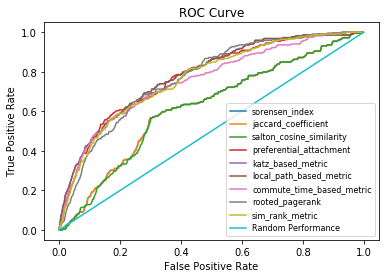

In [86]:
import matplotlib.pyplot as plt
for method_name in method_names:
    TPs, FPs, FNs, TNs = eval_dict[method_name]
    
    FPRs = [FPs[i] / (FPs[i] + TNs[i]) for i in range(len(FPs))]
    TPRs = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(TPs))]
    plt.plot(FPRs, TPRs,'-', label = method_name)
    
# plot graph
x = np.arange(0, 1.1, 0.1)
plt.plot(x, x,'-', label='Random Performance')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# save graph to local file
plt.legend(prop={'size': 8})
plt.savefig("ROC_forum.png", dpi=800) # save as png
plt.show()

In [94]:
TPs, FPs, FNs, TNs = eval_dict["katz_based_metric"]
print(TPs)

[2, 8, 16, 18, 24, 28, 30, 37, 40, 42, 44, 46, 48, 52, 54, 57, 60, 63, 65, 68, 71, 72, 73, 73, 75, 77, 80, 81, 82, 85, 85, 88, 92, 93, 93, 94, 95, 96, 96, 100, 100, 102, 103, 103, 104, 104, 104, 107, 109, 109, 109, 109, 109, 113, 114, 115, 117, 118, 118, 119, 121, 121, 121, 122, 123, 123, 123, 123, 124, 125, 125, 125, 127, 127, 129, 129, 130, 131, 131, 132, 134, 135, 136, 136, 136, 137, 138, 140, 140, 140, 141, 141, 141, 142, 142, 142, 144, 144, 145, 145, 145, 146, 147, 150, 151, 152, 152, 152, 152, 153, 153, 153, 153, 153, 156, 156, 156, 156, 158, 158, 159, 161, 161, 161, 162, 162, 162, 162, 162, 162, 163, 164, 164, 164, 164, 165, 165, 166, 166, 166, 166, 167, 168, 168, 171, 171, 171, 172, 172, 172, 172, 173, 174, 174, 175, 175, 175, 176, 176, 176, 176, 177, 178, 179, 179, 179, 179, 179, 179, 180, 180, 181, 182, 182, 182, 182, 182, 182, 182, 183, 183, 184, 186, 186, 187, 187, 188, 188, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 193, 193, 193, 193, 

In [95]:
TPs, FPs, FNs, TNs = eval_dict["jaccard_coefficient"]
print(TPs)

[0, 0, 0, 0, 1, 1, 1, 2, 5, 6, 6, 7, 7, 9, 9, 11, 12, 12, 13, 14, 14, 15, 17, 17, 18, 20, 20, 20, 20, 20, 21, 24, 27, 27, 30, 35, 36, 37, 37, 40, 42, 42, 43, 44, 46, 46, 47, 48, 48, 49, 49, 50, 51, 52, 53, 54, 55, 55, 59, 61, 63, 63, 65, 66, 66, 66, 66, 66, 68, 68, 68, 68, 68, 69, 71, 71, 72, 74, 74, 77, 77, 78, 78, 78, 78, 78, 78, 79, 79, 81, 83, 84, 86, 88, 88, 91, 93, 96, 99, 99, 99, 102, 102, 104, 105, 107, 107, 109, 111, 112, 116, 122, 124, 124, 124, 125, 125, 125, 126, 126, 126, 126, 127, 128, 128, 129, 130, 131, 131, 131, 131, 132, 133, 133, 133, 133, 133, 133, 133, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 142, 142, 142, 142, 144, 145, 145, 145, 146, 146, 146, 146, 146, 147, 148, 148, 148, 150, 151, 151, 151, 151, 153, 153, 153, 154, 154, 154, 155, 155, 155, 156, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 162, 162, 162, 

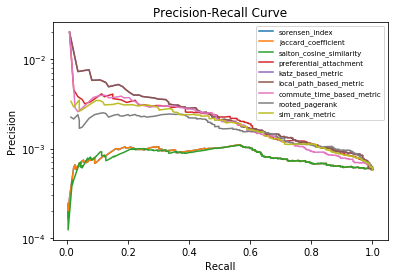

In [98]:
for method_name in method_names:
    TPs, FPs, FNs, TNs = eval_dict[method_name]
    precisions = []
    recalls = []
    for i in range(len(TPs)):
        if TPs[i] == 0 or TPs[i] + FPs[i] == 0 or TPs[i] + FNs[i] == 0:
            continue
        precisions.append(TPs[i] / (TPs[i] + FPs[i])) # tp / tp + fp
        recalls.append(TPs[i] / (TPs[i] + FNs[i])) # tp / tp + fn
#     precisions = [TPs[i] / (TPs[i] + FPs[i]) for i in range(len(TPs))] # tp / tp + fp
#     recalls = [TPs[i] / (TPs[i] + FNs[i]) for i in range(len(TPs))] # tp / tp + fn
    plt.plot(recalls, precisions,'-', label = method_name)
# x = np.arange(0, 1.1, 0.1)
# y = [0.5 for i in x]

# plt.plot(x, y,'-', label='Random Performance')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.yscale('log')

plt.legend(prop={'size': 7})
plt.savefig("Precision-Recall_forum.png", dpi=800) # save as png
plt.show()

In [48]:
print(eval_dict)

{'sorensen_index': ([2, 48, 86, 110, 140, 173, 195, 214, 239, 256, 270, 283, 299, 314, 329, 340, 353, 362, 376, 387, 397, 401, 410, 421, 434, 441, 451, 456, 460, 463, 473, 479, 486, 491, 500, 504, 513, 517, 524, 531, 538, 543, 544, 552, 559, 566, 569, 574, 577, 578, 584, 589, 594, 597, 602, 603, 610, 615, 621, 625, 627, 630, 633, 635, 640, 643, 645, 647, 648, 650, 651, 652, 657, 658, 662, 663, 664, 665, 666, 668, 669, 675, 677, 680, 682, 685, 687, 691, 695, 697, 699, 702, 705, 707, 709, 713, 714, 715, 716, 718, 720, 722, 722, 722, 723, 727, 729, 732, 734, 737, 737, 739, 741, 745, 746, 749, 749, 751, 752, 755, 755, 757, 758, 758, 758, 760, 761, 761, 762, 762, 763, 766, 767, 770, 771, 772, 772, 774, 774, 775, 777, 777, 778, 779, 781, 783, 783, 784, 785, 788, 788, 788, 790, 792, 794, 794, 795, 795, 796, 797, 798, 798, 798, 799, 800, 800, 802, 802, 802, 803, 807, 807, 809, 809, 811, 812, 812, 812, 812, 813, 813, 813, 814, 814, 814, 814, 814, 814, 814, 814, 815, 816, 816, 817, 817, 817, 819

In [26]:
import matplotlib.pyplot as plt
# runtime_list = [("sorensen_index", 27.09092879295349), ("jaccard_coefficient", 25.885604858398438), ("salton_cosine_similarity", 24.5566189289093), ("preferential_attachment", 2.428096055984497), ("katz_based_metric", 3928.244481086731), ("local_path_based_metric",3872.1378161907196), ("rooted_pagerank", 43.99491000175476), ("sim_rank_metric", 3.515040874481201), ("commute_time", 8.456705093383789)] #sim_rank_metric
# runtime_list = [("sorensen_index", 12.99717116355896), ("jaccard_coefficient", 12.888545036315918), ("salton_cosine_similarity", 12.54797101020813), ("preferential_attachment", 1.6181550025939941), ("katz_based_metric", 587.9814021587372), ("local_path_based_metric",3872.1378161907196), ("rooted_pagerank", 43.99491000175476), ("sim_rank_metric", 3.515040874481201), ("commute_time", 8.456705093383789)]
runtime_list = sorted(runtime_list, key=lambda x: x[1], reverse=True)

method_names = []
runtimes = []
for item in runtime_list:
    method_names.append(item[0])
    runtimes.append(item[1])
    

y_pos = np.arange(len(method_names))
 
plt.barh(y_pos, runtimes, align='center', alpha=0.5)
plt.yticks(y_pos, method_names)
plt.xscale('log')

plt.xlabel('Runtime [s]')

plt.title('Runtime Comparision')

plt.savefig("Runtime_Comparision.png", dpi=800, bbox_inches = 'tight') # save as png
plt.show()

<Figure size 640x480 with 1 Axes>

In [80]:
true_link_g = nx.Graph()
for link in true_links:
    if not email_train_g.has_edge(link[0], link[1]):
        true_link_g.add_edge(link[0], link[1])

In [91]:
nx.write_gml(full_graph, "ground_truth_graph.gml")

In [23]:
D_inv = np.linalg.pinv(D)
e = 0.2
RPR = (1 - e)*np.linalg.pinv((np.identity(num_nodes) - e*np.matmul(D_inv, A.todense())))

In [41]:
print(len(email_train_g.edges()))

15203


In [25]:
nodelist = sorted(G.nodes)
print(RPR[nodelist.index('0'), nodelist.index('111')])

9.706658619597145e-05


In [51]:
print(len(facebook.edges()))

80534


In [19]:
c = compute_num_of_path(email_train_g, '587', '245', 3)
cutoff = 3
beta = 0.8
curB = 1
katz = 0
for i in range(1, cutoff + 1):
    curB *= beta
    katz += curB * c[i]
print(katz)

380.1920000000001
